## High-z galaxies with Te measurements

# Determine metallicities using the direct method

In [1]:
## Global stuff
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table


## Lines to be used
line_names = ['OIII1661','OIII1666','NIII1750','CIII1907','CIII1909','NeIII3869','OII3727','OII3729','OIITot',
              'Hd','Hg','OIII4363','Hb','OIII4959','OIII5007','Ha','NII6584']

#Probably there is a smart way of doing this with PyNeb
super_wav = {
    'OIII1661': 1661,
    'OIII1666': 1666,
    'NIII1750': 1750,
    'CIII1907': 1907,
    'CIII1909': 1909,
    'NeIII3869': 3869,
    'OII3727': 3727,
    'OII3729': 3729,
    'OIITot': 3729,
    'Hd': 4102,
    'Hg': 4340,
    'OIII4363': 4363,
    'Hb': 4861,
    'OIII4959': 4959,
    'OIII5007': 5007,
    'Ha': 6563,
    'NII6584': 6584
    }

# Quick look at all fluxes

In [2]:
# Load data
fluxes = Table.read('data_dered.dat',format='ascii.fixed_width_two_line')
fluxes.show_in_notebook()

idx,Name,E(B-V),eE(B-V),OIII1661,OIII1666,NIII1750,CIII1907,CIII1909,NeIII3869,OII3727,OII3729,OIITot,Hd,Hg,OIII4363,Hb,OIII4959,OIII5007,Ha,NII6584,eOIII1661,eOIII1666,eNIII1750,eCIII1907,eCIII1909,eNeIII3869,eOII3727,eOII3729,eOIITot,eHd,eHg,eOIII4363,eHb,eOIII4959,eOIII5007,eHa,eNII6584
0,CSWA20,0.0,0.161025823687,0.125518073726,0.313703532067,nan,0.402755083111,0.369779855978,0.8542610925,1.10214748957,1.21915727026,1.10193060966,nan,1.22733620276,0.107256542479,1.98371773696,3.26733188876,9.66040948186,5.52286617357,0.099632709863,1.02892321161,0.467637814623,nan,0.255023767168,0.257567472781,0.247545910036,0.245632354776,0.248698380047,0.489489420176,nan,0.255051259967,0.645980038673,0.245971158072,0.242535978853,0.241792484249,0.229984560112,0.400362207978
1,UDS-12539,0.0,0.0,nan,nan,nan,nan,nan,3.29065e-17,7.35208e-17,8.08939e-17,1.544147e-16,nan,2.9366e-17,3.95775e-17,1.20361e-16,nan,5.72444e-16,4.07651e-16,1.79054e-17,nan,nan,nan,nan,nan,6.27673e-18,2.50988e-17,2.89959e-17,5.40947e-17,nan,2.29637e-18,3.30824e-18,3.69689e-18,nan,3.2338e-18,1.32121e-18,1.34166e-18
2,Abell_860_359,0.0914412307101,0.0509723273098,0.0422417770783,0.116858700767,0.0422728006925,nan,nan,nan,nan,nan,1.54853230121,nan,nan,nan,1.22749737011,2.48153375706,7.46666063033,3.45858457535,nan,nan,0.366694453593,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0970142847801,0.0926982918155,0.0926081374049,0.0822698957286,nan
3,Abell_22.3,0.24786555689,0.331675694093,nan,nan,nan,nan,nan,nan,nan,nan,1.11,nan,nan,0.27,1.0,1.98,6.45,5.03,0.05,nan,nan,nan,nan,nan,nan,nan,nan,0.3,nan,nan,0.1,0.1,0.3,0.3,0.4,nan
4,RCSGA,0.215364338122,0.287601518269,nan,nan,nan,nan,nan,32.8153288283,nan,nan,311.002245756,28.2748930312,50.3833267201,5.56207717935,105.039705689,156.080041547,497.765762268,277.962868419,17.6778103473,nan,nan,nan,nan,nan,0.354960684212,nan,nan,0.312132739891,0.39639270511,0.351334250528,nan,0.324798401197,0.325184034086,0.323912621968,0.324028223766,0.362128129944
5,A1689_31.1,0.0124894281649,0.301443141737,21.0908326708,48.749062984,nan,34.6109210428,67.1886245268,25.4325133424,37.5087338591,47.6858474955,85.1824113382,nan,60.2136231138,21.8243673201,132.116373078,190.533140255,632.792376232,nan,nan,0.319170020911,0.2964920731,nan,0.298283945799,0.289059425137,0.507198389509,0.333871329107,0.33141441029,0.33246729235,nan,0.350559081787,0.438244194992,0.351012936207,0.372311856553,0.333380275997,nan,nan
6,SMACS_0304,0.268112932242,0.22681010004,0.0636726052554,0.104564528225,nan,nan,nan,0.908139093801,2.70751586913,3.63051382099,6.49189290197,0.746216380128,1.13784816623,nan,2.47754776348,3.25725163935,11.3684635091,7.07199071594,0.227084446847,0.348505436195,0.32525889387,nan,nan,nan,12.6783898038,3.8936990755,3.3332888396,0.287916234925,0.28921214243,0.288931472809,nan,0.288203157321,0.287912480721,0.287738384479,0.279135050662,0.282284704213
7,MACS_0451,0.0,0.0395132980353,0.2,0.3,0.1,nan,nan,nan,nan,nan,0.63,nan,nan,nan,1.0,1.37,3.95,2.58,0.065,0.1,0.1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.1,0.05,0.05,0.16,nan
8,COSMOS_12805,0.279197409042,0.171115382346,0.049,0.075,0.042,nan,nan,nan,nan,nan,2.9,nan,nan,nan,1.0,1.89,6.46,2.84,0.1,0.012,0.015,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.3,0.42,0.29,0.05,nan
9,BX660,0.0,0.100844531147,0.0,0.21,nan,nan,nan,nan,nan,nan,0.87,nan,nan,nan,1.0,3.2,6.4,2.77,0.07,0.0,0.04,nan,nan,nan,nan,nan,nan,0.04,nan,nan,nan,0.2,0.8,0.3,0.2,nan


## Using PyNeb/Izotov2006

In [3]:
## Temperatures from Izotov 2009
def Izotov06_TOIII(f,t):
    """ Equation 1 of Izotov 2006. Only works if OIII4663 is seen. Neglecting density.
    """
    t *= 1e-4
    CT = 8.44 - 1.09*t + 0.5*t**2 - 0.08*t**3 # Here we are neglecting the density
    new_t = 1.432 /(np.log10((f['OIII4959'] + f['OIII5007'])/f['OIII4363']) - np.log10(CT))
    return new_t * 1e4

def calculate_TOIII(f):
    
    params = Parameters()
    params.add('t', value=10000., min=1000., max=30000.)
    
    def fnc(params,f):
        t = params['t']
        return t - Izotov06_TOIII(f,t)
    
    fit = minimize(fnc, params,args=(f,),method='least_squares')
    
    return fit.params['t'].value
    
    
def Izotov06_TOII(tOIII,Z='intermediate'):
    """Equation 14 of Izotov 2006. The dispersion of this relation is not provided
    """
    tOIII *= 1e-4 
    if Z == 'low': # 7.2
        return (-0.577 + tOIII * (2.065 - 0.498*tOIII))*1e4 
    elif Z == 'intermediate': #7.6
         return (-0.744 + tOIII * (2.338 - 0.610*tOIII))*1e4 
    elif Z == 'high': # 8.2
        return (2.967 + tOIII * (-4.797 + 2.827*tOIII))*1e4 
    else:
        print('Wrong "Z" option')

In [4]:
# Calculate metallicities
import pyneb as pn
pn.atomicData.setDataFile('o_iii_coll_AK99.dat') # have to change because the default ones do not have level 6
O3 = pn.Atom('O', 3)
O2 = pn.Atom('O',2)

dered_fluxes = Table.read('data_dered.dat',format='ascii.fixed_width_two_line')
Te_data = Table.read('data_Te.dat',format='ascii.fixed_width_two_line')
Te_data.add_index('Name')

O_H_pyneb = []
O2_H_pyneb = []
met_pyneb = []

def sum_met(OH,O2H):
    return 12 + np.log10(10**(OH-12)+10**(O2H-12))

for f in dered_fluxes:
    
    Te = Te_data.loc[f['Name']]['Te']
    Den = Te_data.loc[f['Name']]['Den']
    
    #  Calculate TOII. take our estimated temperatures as TOIII.
    t_low = (Izotov06_TOII(Te,Z='low')) # May need to change the Z
    t_inter = (Izotov06_TOII(Te,Z='intermediate')) # May need to change the Z
    t_high = (Izotov06_TOII(Te,Z='high')) # May need to change the Z

    def change_scale(x):
        return 12+np.log10(x)
    
    # Calculate metalliticites
    O2_H_pyneb.append(change_scale(O3.getIonAbundance((f['OIII4959']+f['OIII5007']),Te,Den,
                                                to_eval='L(4959)+L(5007)',Hbeta=f['Hb'])))
    
    O_H_pyneb.append(change_scale(O2.getIonAbundance((f['OIITot']),t_inter,Den,
                                                     to_eval='L(3726)+L(3729)',Hbeta=f['Hb'])))
    
    met_pyneb.append(sum_met(O2_H_pyneb[-1],O_H_pyneb[-1]))
    
    a = change_scale(O2.getIonAbundance((f['OIITot']),t_low,Den, to_eval='L(3726)+L(3729)',Hbeta=f['Hb']))
    b = change_scale(O2.getIonAbundance((f['OIITot']),t_inter,Den, to_eval='L(3726)+L(3729)',Hbeta=f['Hb']))
    c = change_scale(O2.getIonAbundance((f['OIITot']),t_high,Den, to_eval='L(3726)+L(3729)',Hbeta=f['Hb']))

    print(a,b,c)
    
    
print('                Name\tO/H\tO+2/H\tMetOH')
for i,f in enumerate(dered_fluxes):
    print('%20s\t%0.2f\t%0.2f\t%0.2f'%(f['Name'],O_H_pyneb[i],O2_H_pyneb[i],met_pyneb[i]))


(7.0057030537517599, 7.006592540965916, 6.8473561717102918)
(9.6062078433313509, nan, nan)
(7.2788114724210349, 7.2801149767446001, 7.0527326507863437)
(7.0139768417090034, 7.2308719222375979, nan)
(7.7489251628072999, 7.7499263451130549, 7.6291508027414121)
(6.6881843633270748, 6.7480126733401935, nan)
(7.846883433231036, 7.8489938854180954, 7.7880606091486886)
(6.6672293444377537, 6.7276497923553533, nan)
(7.6970036289888917, 7.6978956222056132, 7.5371690809096723)
(6.9082165741354453, 6.9240034276090432, 6.3105887703975823)
(7.1414299677532318, 7.1477902696993558, 6.7119253875060609)
(7.0123120110435293, 7.0188221594853255, 6.578462257884258)
(7.7467757171842493, 7.7477424915311905, 7.6223162690345507)
(6.7878129861163705, 6.795556469823393, 6.3217493064193171)
(7.4066590355208932, 7.4123202828237318, 7.3956771601896349)
                Name	O/H	O+2/H	MetOH
              CSWA20	7.01	7.96	8.01
           UDS-12539	nan	nan	nan
       Abell_860_359	7.28	8.01	8.08
          Abell_22.3	7

## Calculate Errors

In [26]:
def change_scale(x):
    return 12+np.log10(x)


def perturbed_lines(f,nb):
    np.random.seed()
    new_lines = {}
    for line in ['OIII4959',"OIII5007","OIITot",'Hb']:
        if np.isfinite(f[line]) and np.isfinite(f['e'+line]):
            new_lines[line] = np.random.normal(f[line],f['e'+line],nb)
        else:
            new_lines[line] = [f[line]] * nb

    return new_lines


In [29]:
# Calculate metallicities with error estimation
from astropy.visualization import hist
import pickle
galaxies = Table.read('data_dered.dat',format='ascii.fixed_width_two_line')
galaxies.remove_row(1)

O_H_pyneb = []
O2_H_pyneb = []
met_pyneb = []
upO_H_pyneb = []
upO2_H_pyneb = []
upmet_pyneb = []
lowO_H_pyneb = []
lowO2_H_pyneb = []
lowmet_pyneb = []

nb = 500

print('                Name\t       O/H\t\t       O+2/H\t\t      MetOH')
for gal in galaxies:
    
    O2_H_sample = []
    O_H_sample = []
    
    #  Sample of fluxes, densitties and TOIII. Calculate TOII
    dered_f = perturbed_lines(gal,nb)
    tem_and_den    = pickle.load( open( 'tem_and_ebv_samples/'+gal['Name']+"_tem_and_ebv.pickle", "rb" ) )
    tOIII_sample  = np.random.choice(tem_and_den['tem'], nb)#np.full_like(dered_f['Hb'],gal['Te'])
    den_sample    = np.random.choice(tem_and_den['den'], nb)#np.full_like(dered_f['Hb'],gal['Den'])  
    tOII_sample   = np.array([Izotov06_TOII(x,Z='low') for x in tOIII_sample]) # May need to change the Z
    
    ## Calculate metalliticites
    O2_H_sample.append(O3.getIonAbundance(np.array(dered_f['OIII4959'])+np.array(dered_f['OIII5007']),
                                          tOIII_sample,den_sample,to_eval='L(4959)+L(5007)',Hbeta=dered_f['Hb']))
    O_H_sample.append(O2.getIonAbundance(np.array(dered_f['OIITot']),
                                          tOII_sample,den_sample,
                                          to_eval='L(3726)+L(3729)',Hbeta=dered_f['Hb']))
    
    total = np.array([change_scale(m1+m2) for  m1,m2 in zip(O2_H_sample,O_H_sample)])
    O2_H_sample = np.array([change_scale(m) for  m in O2_H_sample])
    O_H_sample  = np.array([change_scale(m) for  m in O_H_sample])
    
    O2_H_pyneb.append(np.nanpercentile(O2_H_sample,50))
    O_H_pyneb.append(np.nanpercentile(O_H_sample,50)) 
    upO2_H_pyneb.append(np.nanpercentile(O2_H_sample,84)-np.nanpercentile(O2_H_sample,50))
    upO_H_pyneb.append(np.nanpercentile(O_H_sample,84)-np.nanpercentile(O_H_sample,50))
    lowO2_H_pyneb.append(np.nanpercentile(O2_H_sample,50)-np.nanpercentile(O2_H_sample,16))
    lowO_H_pyneb.append(np.nanpercentile(O_H_sample,50)-np.nanpercentile(O_H_sample,16))
    met_pyneb.append(np.nanpercentile(total,50))
    upmet_pyneb.append(np.nanpercentile(total,84)-np.nanpercentile(total,50))
    lowmet_pyneb.append(np.nanpercentile(total,50)-np.nanpercentile(total,16))

    print('%20s\t%0.2f + %0.2f - %0.2f\t%0.2f + %0.2f - %0.2f\t%0.2f + %0.2f - %0.2f'%(gal['Name'],
                                                               O_H_pyneb[-1],upO_H_pyneb[-1],lowO_H_pyneb[-1],
                                                               O2_H_pyneb[-1],upO2_H_pyneb[-1],lowO2_H_pyneb[-1],
                                                              met_pyneb[-1],upmet_pyneb[-1],lowmet_pyneb[-1]))


                Name	       O/H		       O+2/H		      MetOH
              CSWA20	7.03 + 0.45 - 0.35	7.98 + 0.33 - 0.23	8.03 + 0.34 - 0.24
       Abell_860_359	7.28 + 0.13 - 0.09	8.00 + 0.12 - 0.09	8.08 + 0.12 - 0.09
          Abell_22.3	7.06 + 0.27 - 0.18	7.39 + 0.19 - 0.09	7.57 + 0.11 - 0.07
               RCSGA	7.75 + 0.03 - 0.03	7.98 + 0.02 - 0.03	8.18 + 0.02 - 0.03
          A1689_31.1	6.72 + 0.09 - 0.03	7.39 + 0.17 - 0.14	7.47 + 0.15 - 0.08
          SMACS_0304	7.87 + 0.23 - 0.11	8.03 + 0.08 - 0.07	8.26 + 0.13 - 0.09
           MACS_0451	6.69 + 0.07 - 0.05	7.34 + 0.15 - 0.11	7.43 + 0.13 - 0.09
        COSMOS_12805	7.71 + 0.18 - 0.21	8.07 + 0.17 - 0.23	8.23 + 0.18 - 0.22
               BX660	6.91 + 0.10 - 0.11	7.82 + 0.12 - 0.18	7.87 + 0.12 - 0.17
                BX74	7.15 + 0.17 - 0.18	7.96 + 0.18 - 0.32	8.03 + 0.18 - 0.29
               BX418	7.02 + 0.17 - 0.16	7.90 + 0.17 - 0.21	7.96 + 0.17 - 0.20
           S16-stack	7.75 + 0.07 - 0.06	7.93 + 0.07 - 0.06	8.15 + 0.07 - 0.06
     

In [31]:
## Save results in a table 
pyneb_out = Table([galaxies['Name'],
                   O_H_pyneb,upO_H_pyneb,lowO_H_pyneb,
                   O2_H_pyneb,upO2_H_pyneb,lowO2_H_pyneb,
                   met_pyneb,upmet_pyneb,lowmet_pyneb],
                names = ['Name','O/H','upO/H','lowO/H','O2/H','upO2/H','lowO2/H','met','upmet','lowmet'])

pyneb_out.write('pyneb_Te_method.dat',format='ascii.fixed_width_two_line')
pyneb_out.show_in_notebook() 

idx,Name,O/H,upO/H,lowO/H,O2/H,upO2/H,lowO2/H,met,upmet,lowmet
0,CSWA20,7.03399904545,0.448267323297,0.346241993701,7.9802485767,0.328779748261,0.231057508949,8.03046945311,0.33601960964,0.241589873257
1,Abell_860_359,7.27776762628,0.131528146828,0.0891494025263,8.00220296283,0.123294033239,0.0903494745404,8.07714085419,0.124179717762,0.0904194991445
2,Abell_22.3,7.05568583626,0.265996870209,0.177179813563,7.39176065803,0.185244190866,0.0854134117861,7.56810864216,0.112213826744,0.0713160349582
3,RCSGA,7.74865166219,0.0253098361765,0.0330344969043,7.9826988579,0.0237043487094,0.0305428227165,8.18238120059,0.0242644765014,0.0315625323728
4,A1689_31.1,6.71933336882,0.0935504573381,0.0275601541413,7.39284299546,0.172446846542,0.144861566821,7.47074346709,0.153671850789,0.0819521722824
5,SMACS_0304,7.86570379025,0.231283738239,0.108028949848,8.0252293237,0.0786748240527,0.0666948707819,8.26337246641,0.133322195939,0.0868293902806
6,MACS_0451,6.69031111879,0.0707093834499,0.0484651670619,7.34284343311,0.145270169444,0.113048099559,7.42657986938,0.130323085313,0.0855472859927
7,COSMOS_12805,7.70838893557,0.184254470075,0.214102717142,8.07442096821,0.173698579414,0.227893669732,8.22982695582,0.177265418164,0.222317138467
8,BX660,6.90983413168,0.0985324453862,0.113207615503,7.82000195818,0.120059214111,0.181618818419,7.86939111086,0.116780352661,0.168627967538
9,BX74,7.14509354974,0.168798520424,0.176575780423,7.96466355967,0.184599723876,0.315273497571,8.02543251438,0.179735310485,0.290116238965


In [32]:
## Write it to paper 

out = open('TeMethod_pyneb_for_paper','w')

out.write('Obj          \t& 12+log (O$^+$/H$^+$) \t& 12+log(O$^{2+}$/H$^+$) \t& 12+log(O/H)$_{\Te}$ \\\\ \n')

for f in pyneb_out:
    out.write("%s \t& %0.2f$^{+%0.2f}_{-%0.2f}$\t& %0.2f$^{+%0.2f}_{-%0.2f}$\t& %0.2f$^{+%0.2f}_{-%0.2f}$\t \\\\ \n"
                  %(f['Name'],f['O/H'],f['upO/H'],f['lowO/H'],
                    f['O2/H'],f['upO2/H'],f['lowO2/H'],
                    f['met'],f['upmet'],f['lowmet']))
                    
out.close()

<IPython.core.display.Javascript object>


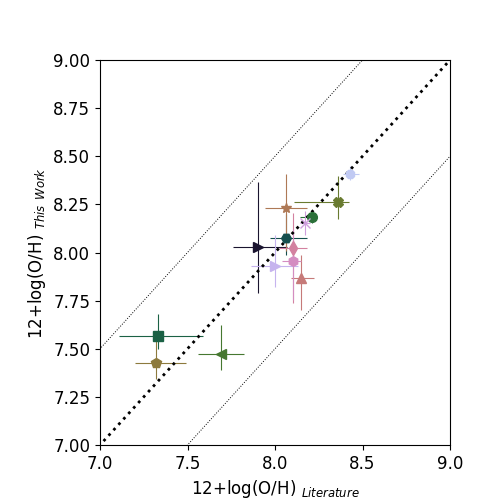

In [42]:
# Compare with previous estimations
plt.rcParams.update({'font.size': 12})
galaxies = Table.read('../Data/galaxy_properties.dat',format='ascii.fixed_width_two_line')
Te = Table.read('pyneb_Te_method.dat',format='ascii.fixed_width_two_line')
Te.add_index('Name')

## colors and markers
colors = plt.get_cmap('cubehelix')(np.linspace(0.1, 0.8, len(galaxies['Name'])))
galaxies.remove_rows([1,2])


#plotting
fig, ax = plt.subplots(1,1,figsize=(5,5))
fig.subplots_adjust(left=0.2)

for gal in galaxies: 
    met = Te.loc[gal['Name']]
    ax.errorbar(gal['MetTe'],met['met'],label=gal['Name'],
                xerr=np.array((np.abs(gal['infMetTe']),gal['supMetTe'])).reshape(2,1),
                yerr=np.array((met['lowmet'],met['upmet'])).reshape(2,1),
                color=colors[gal['nb']],marker=gal['marker'],
                markersize=7,elinewidth=0.8)

ax.plot(np.arange(6.0,10.),np.arange(6.0,10.),color='k',linewidth=2.0,linestyle=':')
ax.plot(np.arange(6.0,10.),np.arange(6.0,10.)+0.5,color='k',linewidth=0.7,linestyle=':')
ax.plot(np.arange(6.0,10.),np.arange(6.0,10.)-0.5,color='k',linewidth=0.7,linestyle=':')
ax.set_ylabel('12+log(O/H) $_{This\,\,\,Work}$')
ax.set_xlabel('12+log(O/H) $_{Literature}$')
ax.set_ylim(7.0,9.0)
ax.set_xlim(7.0,9.0)

fig.savefig('/Users/vera/Desktop/DirectMethod_Lit.pdf')
